# Adaptation of Borlase model

This model will mimic the approach of the translation of the Borlase R code. At each timestep, the age, infective status, bacterial load etc. of each person (represented by the indices) is stored, and we may retrieve the number of infectives at each time for plotting. Time is in weeks (multiply by 7 to retrieve days) and people are split into three general age groups: young children, old children, and adults

The treatment matrix keeps track of who receives MDA treatment and when, allowing for SNC
Vaccination treatment should use a different matrix (when incorporated)

Simulation parameters: simulation time, burn-in (time until MDA starts), MDA (soon to include vax) frequency, number of rounds of MDA (and vax)

Population parametes: N, duration of infection/disease, reduction of infection/diseaes, durations of infection and disease, parameters for lambda function, MDA (soon vax) coverage and efficiency, and rho (ommitted, related to SNC) 

Demographic parameters: tau (death rate), max age, mean age

In [5]:
# importing relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

## Calculating infection rate and resetting individuals who die or reach maximum age

In [6]:
# rate depends on parameters and diseased individuals
def lambda_rate(params, Age, demog, bact_load, IndD, bet):
    v_1, v_2, phi, epsilon = params['v_1'], params['v_2'], params['phi'], params['epsilon']
    N, max_age = params['N'], demog['max_age']
    
    totalLoad = [0,0,0]
    y_children = np.where((Age >= 0) & (Age < 9*52))[0] # young children = 0-9
    totalLoad[0] = np.sum(bact_load[y_children]) / len(y_children) # average bacterial load?
    o_children = np.where((Age >= 9*52) & (Age < 15*52))[0] # older children = 9-15
    totalLoad[1] = np.sum(bact_load[o_children]) / len(o_children)
    adults = np.where(Age >= 15*52)[0]
    totalLoad[2] = np.sum(bact_load[adults]) / len(adults)
    
    prevLambda = bet * (v_1 * np.array(totalLoad) + v_2 * np.array(totalLoad) ** (phi + 1))
    
    # tile function repeats proportions, forming 3 identical rows
    demog_matrix = np.transpose(np.tile(np.array([len(y_children), len(o_children), len(adults)]) / N, (3, 1)))
    social_mixing = (epsilon * np.eye(3) + (1 - epsilon)) * demog_matrix
    
    lambda_ = np.dot(social_mixing, prevLambda)
    
    # adjust lambda based on disease status
    age_intervals = np.searchsorted([0, 9*52, 15*52, max_age*52], Age)
    adjusted_lambda = lambda_[age_intervals - 1] * (0.5 + 0.5 * (1 - IndD))
    
    return adjusted_lambda # relates to force of infection across the population

def reset_age(Age, demog, params):
    tau, max_age, N = demog['tau'], demog['max_age'], params['N']
    # individuals who die or reach the maximum age will be recorded and reset later
    reset_indivs = np.where((np.random.uniform(size=N) < 1 - np.exp(-tau)) | (Age > max_age))[0]
    return reset_indivs

## Treatment matrix. Child-only matrix is ignored for now

In [7]:
# decide who gets treatment when
def tx_matrix(params, sim_params):
    N, N_MDA, MDA_Cov, rho = params['N'], sim_params['N_MDA'], params['MDA_Cov'], params['rho']
    ind_treat = np.zeros((N, N_MDA)) # must be an N by N_MDA matrix
    
    for i in range(N): # work through each individual
        z = np.random.uniform(size = N)
        ind_treat[:, 0] = z < MDA_Cov # chosen so roughly MDA_Cov% of people get the first treatment
        for k in range(1, N_MDA): # determine which rounds each person receives
            prob = (MDA_Cov * (1 - rho) + (rho * np.sum(ind_treat[i, :k]))) / (1 + (k - 1) * rho) # decrease with rho, k
            ind_treat[i, k] = np.random.binomial(1, prob) # determine if individual i receives round k
    
    return ind_treat

## Timesteps for MDA and indexing who is cured

In [8]:
# return the timestamps of when MDA occurs
def set_t_MDA(sim_params):
    burnin, N_MDA, freq_MDA = sim_params['burnin'], sim_params['N_MDA'], sim_params['freq_MDA']
    MDA_times = []
    for i in range(N_MDA): # add the time of each round
        MDA_times.append(burnin + i * 52 * freq_MDA + 52) # add 52 to start 1 year after burnin
        
    return MDA_times

# timestamps for child-only MDA
def set_t_MDA_kids(sim_params):
    burnin, N_MDA_kids, freq_MDA_kids = sim_params['burnin'], sim_params['N_MDA_kids'], sim_params['freq_MDA_kids']
    child_delay, offset = sim_params['child_delay'], sim_params['offset'] # relates child-only times to community-wide ones
    MDA_times_kids = []
    for i in range(N_MDA_kids):
        MDA_times_kids.append(burnin + child_delay + i * 52 * freq_MDA_kids + 52 + offset)
    
    return MDA_times_kids

# decide who is treated during community-wide MDA
def doMDA(params, Age, MDA_round, tx_mat):
    MDA_eff = params['MDA_eff']
    
    babies = np.where(Age < 26)[0] # identify who is a baby
    treated_b = babies[np.where(tx_mat[babies, MDA_round-1] == 1)[0]] # identify which baby is due treatment
    cured_b = treated_b[np.where(np.random.uniform(size = len(treated_b)) < (MDA_eff * 0.5))[0]] # multiplier due to method
    
    older = np.where(Age > 26)[0]
    treated_o = older[np.where(tx_mat[older, MDA_round-1] == 1)[0]]
    cured_o = treated_o[np.where(np.random.uniform(size = len(treated_o)) < MDA_eff)[0]]
    
    all_cured = np.concatenate((cured_b, cured_o))
    
    return all_cured # returns index of all individuals who are treated and successfully cured

# decide who is treated during children-only MDA - ignore matrix and SNC due to complications with ageing/death
def doMDAkids(params, Age, MDA_round_kids):
    MDA_eff = params['MDA_eff']
    MDA_Cov_kids = params['MDA_Cov_kids']
    
    kids = np.where((Age > 104) & (Age < 10 * 52))[0] # look at 2-10 year olds here (why not 1-9?)
    treated_kids = kids[np.where(np.random.uniform(size = len(kids)) < MDA_Cov_kids)[0]] # randomly select enough indiv's
    cured_kids = treated_kids[np.where(np.random.uniform(size = len(treated_kids)) < MDA_eff)[0]] # successful treatment
    
    return cured_kids

## Function which actually carries out MDA steps

In [9]:
# carry out community-wide MDA
def MDA_timestep(vals, params, demog, MDA_round):
    
    IndI = vals['IndI'] # retrieve the variables for each individual
    IndD = vals['IndD']
    No_Inf = vals['No_Inf']
    T_latent = vals['T_latent']
    T_ID = vals['T_ID']
    T_D = vals['T_D']
    Ind_latent = vals['Ind_latent']
    Ind_ID_period_base = vals['Ind_ID_period_base']
    Ind_D_period_base = vals['Ind_D_period_base']
    bact_load = vals['bact_load']
    Age = vals['Age']
    
    all_cured = doMDA(params, Age, MDA_round, tx_mat) # identify who is cured through MDA
    
    IndI[all_cured] = 0 # reset infection and bacterial load for scuccessfully cured individuals
    bact_load[all_cured] = 0
    
    vals = { # put all the updated variables back together
        "IndI": IndI,
        "IndD": IndD,
        "No_Inf": No_Inf,
        "T_latent": T_latent,
        "T_ID": T_ID,
        "T_D": T_D,
        "Ind_latent": Ind_latent,
        "Ind_ID_period_base": Ind_ID_period_base,
        "Ind_D_period_base": Ind_D_period_base,
        "bact_load": bact_load,
        "Age": Age
    }
    
    
    return vals

# carry out child-only MDA
def MDA_timestep_kids(vals, params, demog, MDA_round_kids):
    
    IndI = vals['IndI']
    IndD = vals['IndD']
    No_Inf = vals['No_Inf']
    T_latent = vals['T_latent']
    T_ID = vals['T_ID']
    T_D = vals['T_D']
    Ind_latent = vals['Ind_latent']
    Ind_ID_period_base = vals['Ind_ID_period_base']
    Ind_D_period_base = vals['Ind_D_period_base']
    bact_load = vals['bact_load']
    Age = vals['Age']
    
    all_cured_kids = doMDAkids(params, Age, MDA_round_kids) # identify which children are cured through MDA
    
    IndI[all_cured_kids] = 0 # reset infection and bacterial load for successfully cured children
    bact_load[all_cured_kids] = 0
    
    vals = {
        "IndI": IndI,
        "IndD": IndD,
        "No_Inf": No_Inf,
        "T_latent": T_latent,
        "T_ID": T_ID,
        "T_D": T_D,
        "Ind_latent": Ind_latent,
        "Ind_ID_period_base": Ind_ID_period_base,
        "Ind_D_period_base": Ind_D_period_base,
        "bact_load": bact_load,
        "Age": Age
    }
    
    
    return vals


## Infection and disease periods, used to set duration upon acquiring disease/infection

In [10]:
# give duration of active infection and disease only periods
def ID_period_function(Ind_ID_period_base, No_Inf, parameters):
    min_ID = parameters['min_ID']
    inf_red = parameters['inf_red']
    T_ID = np.round((Ind_ID_period_base - min_ID) * np.exp(-inf_red * (No_Inf - 1)) + min_ID)
    
    return T_ID
    
# give duration of diseased period
def D_period_function(Ind_D_period_base, No_Inf, parameters):
    min_D = parameters['min_D']
    dis_red = parameters['dis_red']
    T_D = np.round((Ind_D_period_base - min_D) * np.exp(-dis_red * (No_Inf - 1)) + min_D)
    
    return T_D

## Run a non-MDA timestep

In [11]:
# transitions which occur during a timestep where MDA does not occur
def stepf_fixed(vals, params, demog, bet):
    
    IndI = vals['IndI']
    IndD = vals['IndD']
    No_Inf = vals['No_Inf']
    T_latent = vals['T_latent']
    T_ID = vals['T_ID']
    T_D = vals['T_D']
    Ind_latent = vals['Ind_latent']
    Ind_ID_period_base = vals['Ind_ID_period_base']
    Ind_D_period_base = vals['Ind_D_period_base']
    bact_load = vals['bact_load']
    Age = vals['Age']
    
    # new I =  Becoming infected, not yet diseased
    Ss = np.where(IndI == 0)[0]  # susceptible individuals available for infection
    lambda_step = 1 - np.exp(-lambda_rate(params, Age, demog, bact_load, IndD, bet)) # probability of infection
    newInf = Ss[np.random.rand(len(Ss)) < lambda_step[Ss]]  # new infections
    
    # new ID = infected and becoming diseased too
    Is = np.where((IndI == 1) & (IndD == 0))[0]
    T_latent -= 1  # with each timestep, subtract 1
    newDis = np.where(T_latent == 0)[0]  # designated latent period for that individual has expired
    T_latent[T_latent < 1] = 0  # reset all not in latent period to 0 at each timestep
    
    # new D = infectious diseased losing infectiousness
    IDs = np.where((IndI == 1) & (IndD == 1))[0]
    bact_load[IDs] = bacterialLoad(No_Inf[IDs], params)
    T_ID -= 1  # with each timestep, subtract 1
    newClearInf = np.where(T_ID == 0)[0]  # designated infectious period for that individual has expired
    T_ID[T_ID < 1] = 0  # reset all uninfected to 0 at each timestep
    
    # new S = Clear disease
    Ds = np.where((IndI == 0) & (IndD == 1))[0]
    bact_load[Ds] = 0
    T_D -= 1  # subtract 1 each timestep
    newClearDis = np.where(T_D == 0)[0]  # designated diseased period for that individual has expired
    T_D[T_D < 1] = 0  # reset all not in diseased period to 0

    No_Inf[newInf] += 1 # tracking infection history

    # TRANSITION become infected
    IndI[newInf] = 1  # if they've become infected, become I=1
    # TRANSITION become diseased (and infected)
    IndD[newDis] = 1  # if they've become diseased they become D=1
    # TRANSITION Clear infection (remain diseased)
    IndI[newClearInf] = 0  # clear infection they become I=0
    # TRANSITION Clear disease (become susceptible again)
    IndD[newClearDis] = 0  # clear disease they become D=0

    # Setting duration of infection/disease for individuals
    T_latent[newInf] = Ind_latent[newInf]  # When individual becomes infected, set their latent period
    # When individual becomes diseased, set their infected+diseased period
    T_ID[newDis] = ID_period_function(Ind_ID_period_base=Ind_ID_period_base[newDis], No_Inf=No_Inf[newDis], parameters=parameters)
    # When indiv clears infection, their diseased only period is set
    T_D[newClearInf] = D_period_function(Ind_D_period_base=Ind_D_period_base[newClearInf], No_Inf=No_Inf[newClearInf], parameters=parameters)

    # Update age, all age by 1w at each timestep, and resetting all "reset indivs" age to zero
    # Reset_indivs - Identify individuals who die in this timeset
    Age += 1
    reset_indivs = reset_age(Age=Age, demog=demog, params=parameters)
    Age[reset_indivs] = 0

    # Resetting new parameters for all new individuals created
    IndI[reset_indivs] = 0
    IndD[reset_indivs] = 0
    No_Inf[reset_indivs] = 0
    T_latent[reset_indivs] = 0
    T_ID[reset_indivs] = 0
    T_D[reset_indivs] = 0

    vals = {
        "IndI": IndI,
        "IndD": IndD,
        "No_Inf": No_Inf,
        "T_latent": T_latent,
        "T_ID": T_ID,
        "T_D": T_D,
        "Ind_latent": Ind_latent,
        "Ind_ID_period_base": Ind_ID_period_base,
        "Ind_D_period_base": Ind_D_period_base,
        "bact_load": bact_load,
        "Age": Age
    }
    
    return vals

## Formula for bacterial load and setting the initial ages and infections in the population

In [12]:
# define bacterial load based on infection history
def bacterialLoad(No_Inf, parameters):
    b1, ep2 = 1, 0.114
    bact_load = b1 * np.exp((No_Inf - 1) * -ep2)
    
    return bact_load

# produce age sample based on exponential distribution and mean age
def init_ages(params, demog):
    max_age, mean_age, N = demog['max_age'], demog['mean_age'], params['N']
    ages = np.arange(1, max_age + 1)
    nAges = len(ages)
    propAges = np.empty(nAges) # will store the probability of lying in each age group
    for i in range(nAges - 1):
        propAges[i] = np.exp(-ages[i] / mean_age) - np.exp(-ages[i + 1] / mean_age) # reflects exponential distribution
    propAges[-1] = 1 - np.sum(propAges[:-1]) # ensures probabilities sum to 1
    sampled_ages = np.random.choice(ages, N, replace=True, p=propAges) # now samples according to distribution
    
    return sampled_ages

# set initial values
def set_inits(params, demog):
    N = params['N']
    av_I_duration = params['av_I_duration']
    av_ID_duration = params['av_ID_duration']
    av_D_duration = params['av_D_duration']
    IndI = np.zeros(N)  # infected status
    IndD = np.zeros(N)  # disease status
    No_Inf = np.zeros(N)  # total number of infections per individual
    T_latent = np.zeros(N)  # duration of latent period (I)
    T_ID = np.zeros(N)  # duration of current ID period
    T_D = np.zeros(N)  # duration spent in diseased state (post-infection)
    Ind_latent = np.full(N, av_I_duration)  # individual's latent period fixed for now
    Ind_ID_period_base = np.random.poisson(av_ID_duration, N)  # baseline ID period
    Ind_D_period_base = np.random.poisson(av_D_duration, N)  # baseline diseased period
    bact_load = np.zeros(N)  # baseline bacterial load set to zero
    Age = init_ages(params, demog)  # initial ages

    vals = {
        "IndI": IndI,
        "IndD": IndD,
        "No_Inf": No_Inf,
        "T_latent": T_latent,
        "T_ID": T_ID,
        "T_D": T_D,
        "Ind_latent": Ind_latent,
        "Ind_ID_period_base": Ind_ID_period_base,
        "Ind_D_period_base": Ind_D_period_base,
        "bact_load": bact_load,
        "Age": Age
    }

    return vals


def seed_infection(params, vals):
    N = params['N']
    
    initial_infected_count = round(N * 0.01) # set 1% of the population to be infected initially
    vals['IndI'][:initial_infected_count] = 1
    
    init_infected = np.where(vals['IndI'] == 1)[0] # get the indices of the initially infected individuals
    
    vals['T_latent'][init_infected] = vals['Ind_latent'][init_infected] # set latent period for those infected at the start of simulation
    
    vals['No_Inf'][init_infected] = 1 # number of infections for those initially infected
    
    return vals

## Parameters (removed 'nsim' from sim_params)

In [185]:
sim_params = {
    'timesim': 80 * 52,  # total duration of simulation in weeks
    'burnin': 40 * 52,   # burn-in period in weeks
    'child_delay': 5 * 52, # begin child-only 5 years after community-wide
    'offset': 26,        # weeks between child-only MDA and community-wide. 26 = 6 months
    'freq_MDA': 1,       # 1 for annual, 0.5 for biannual, 2 for every 2 years, etc.
    'freq_MDA_kids': 5, # child-only frequency
    'N_MDA': 40,         # number of rounds of MDA to be carried out in simulation
    'N_MDA_kids': 7,    # self-explanatory
}

parameters = {
    'N': 3000,                    # population size
    'av_I_duration': 2,           # average duration of infection
    'av_ID_duration': 200 / 7,    # average duration of ID period
    'inf_red': 0.45,              # infection reduction
    'min_ID': 11,                 # minimum ID duration
    'av_D_duration': 300 / 7,     # average duration of disease period
    'dis_red': 0.3,               # disease reduction
    'min_D': 1,                   # minimum disease duration
    'v_1': 1,                     # parameter for lambda function
    'v_2': 2.6,                   # parameter for lambda function
    'phi': 1.4,                   # parameter for lambda function
    'epsilon': 0.5,               # parameter for lambda function
    'MDA_Cov': 0.7,               # MDA coverage, baseline = 0.8
    'MDA_Cov_kids': 1,            # MDA coverage during child-only MDA
    'MDA_eff': 0.85,              # efficacy of treatment, baseline = 0.85
    'rho': 0                      # correlation parameter for systematic non-compliance function
}

demog = {
    'tau': 1 / (40 * 52),   # death rate in weeks^-1
    'max_age': 60 * 52,     # maximum age in population in weeks
    'mean_age': 20 * 52     # mean age in population in weeks
}

## Code to run a single simulation, with MDA times specified. Output is times, diseases, and infections

In [155]:
def sim_ind_MDA(params, vals, timesim, demog, bet):
    
    vals = vals
    prev_disease = []
    prev_infection = []
    prev_diseases_1_9 = []
    prev_infection_1_9 = []
    t = []
    MDA_round = []
    MDA_round_kids = []
    
    pop_29 = []
    pop_015 = []
    
    for i in range(1, timesim+1): # assume timesim is the total number of timesteps
        if i in MDA_times:
            MDA_round_i = MDA_times.index(i) + 1 # determine round of MDA
            MDA_round.append(MDA_round_i)
            vals = MDA_timestep(vals, params, demog, MDA_round_i) # update values following this MDA round
            
            t.append(i/52)
            prev_disease.append(sum(vals['IndD']) / params['N']) # add the latest prevalences to each array
            prev_infection.append(sum(vals['IndI']) / params['N'])
        
        elif i in MDA_times_kids:
            MDA_round_kids_i = MDA_times_kids.index(i) + 1
            MDA_round_kids.append(MDA_round_kids_i)
            vals = MDA_timestep_kids(vals, params, demog, MDA_round_kids_i) # ROUND technically not needed as totally random
            
            t.append(i/52)
            prev_disease.append(sum(vals['IndD']) / params['N'])
            prev_infection.append(sum(vals['IndI']) / params['N'])
        
        else:
            vals = stepf_fixed(vals, params, demog, bet)
            
            t.append((i-1)/52)
            prev_disease.append(sum(vals['IndD']) / params['N'])
            prev_infection.append(sum(vals['IndI']) / params['N'])
            
        Age = vals['Age']
        kids_29 = np.where((Age > 104) & (Age < 10 * 52))[0]
        kids_015 = np.where((Age >= 0) & (Age < 15*52))[0]
        pop_29.append(len(kids_29) / params['N'])
        pop_015.append(len(kids_015) / params['N'])
            
    output = {
        "times": t,
        "infections": prev_infection,
        "diseases": prev_disease,
        "infection_1_9": prev_infection_1_9,
        "diseases_1_9": prev_diseases_1_9,
        "pop_29": pop_29,
        "pop_015": pop_015,
    } 
            
    return output

## Set up initial parameters before running

In [186]:
# create matrices and times
timesim, burnin = sim_params['timesim'], sim_params['burnin']
delay, offset = sim_params['child_delay'], sim_params['offset']

tx_mat = tx_matrix(parameters, sim_params)
# tx_mat_kids = tx_matrix_kids(parameters, sim_params) - AVOIDED until we decide how to address the life-cycle issue

bet = np.random.uniform(0.165, 0.175)

MDA_times = set_t_MDA(sim_params) # determine times of MDA using simulation parameters

MDA_times_kids = set_t_MDA_kids(sim_params) # do this inbetween community times for simplicity (avoids priority issues)

## Run the simulation once and plot

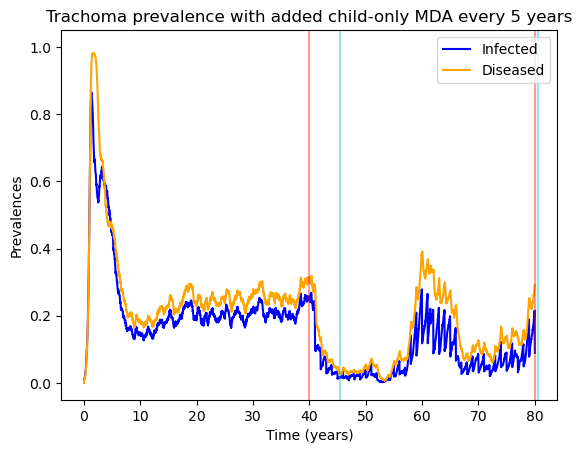

In [190]:
# set initial values and infections
def set_initial_conditions(params, demog):
    vals1 = set_inits(params, demog)
    vals2 = seed_infection(params, vals1)
    return vals2

vals = set_initial_conditions(parameters, demog) # set before each run to avoid re=using the previous end values

# run simulation
output = sim_ind_MDA(parameters, vals, timesim, demog, bet)

# add extra for child-only prevalences
times, infections, diseases = output['times'], output['infections'], output['diseases']

# plot time against infections

plt.plot(times, infections, color = 'blue', label = 'Infected')
plt.plot(times, diseases, color = 'orange', label = 'Diseased')
plt.xlabel('Time (years)')
plt.ylabel('Prevalences')
plt.title('Trachoma prevalence with added child-only MDA every 5 years')
plt.legend()
plt.ylim([-0.05, 1.05])

# lines to indicate the start and end of community-wide intervention          
plt.axvline(x=burnin/52, color = 'r', alpha = 0.4)
plt.axvline(x=burnin/52 + sim_params['N_MDA']*sim_params['freq_MDA'], color = 'r', alpha = 0.4)

# lines to indicate start and end of child-only intervention
plt.axvline(x=(burnin+delay+offset)/52, color = 'c', alpha = 0.4)
plt.axvline(x=(burnin+delay+offset)/52 + sim_params['N_MDA_kids']*sim_params['freq_MDA_kids'], color = 'c', alpha = 0.4)

(0.1, 0.6)

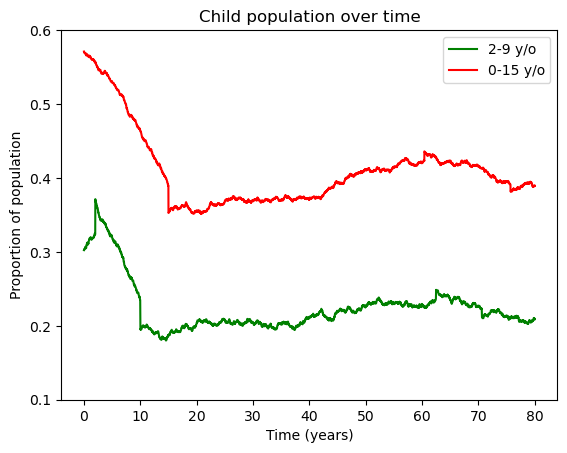

In [133]:
# plotting the proportion of the population made up by 2-9 and 0-15 year olds
pop_29, pop_015 = output['pop_29'], output['pop_015']
plt.plot(times, pop_29, color = 'green', label =  '2-9 y/o')
plt.plot(times, pop_015, color = 'red', label = '0-15 y/o')
plt.xlabel('Time (years)')
plt.ylabel('Proportion of population')
plt.title('Child population over time')
plt.legend()
plt.ylim([0.1, 0.6])

## Run many simulations (decide what to do with this)

In [18]:
# in place of the randomly sampled array of 'bet', just create this before each simulation